# Analysis of environmental data
In this notebook, we will analyze the oceanographic data collected during the Spring Campaign of 2023. The data was collected using a CTD (Conductivity, Temperature, Depth) sensor and the ships underway system. The CTD sensor was deployed every hour at 4 different locations in the Southern North Sea. We'll start with importing the data into this notebook for analysis.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np

## CTD Data

In [2]:
ctd_data = pd.read_csv('../data/raw/environmental_data.csv', sep=';', index_col=0)
# Make sure the index is a DateTimeIndex type to manipulate dates efficiently
ctd_data.index = pd.to_datetime(ctd_data.index)

# Only include data from stations 51 and 130
ctd_data = ctd_data[ctd_data['StationPrefix'].isin(['51', '130'])]

# It looks like the time is off by two hours (it is in UST), so we'll add two hours to the index
ctd_data.index = ctd_data.index + pd.Timedelta(hours=2)

In [3]:
ctd_data['Day'].unique()

array([18, 19, 20, 21])

Now, let's add time of high and low tides. We downloaded tidal predictions from the [Flanders Maritime Agency](https://www.agentschapmdk.be/nl/publicaties#getijgegevens-2023), and used the tables for Vlissingen (Station 51) and Ostend (Station 130). In Vlissingen we sampled from 18/04/2023 13:00 to 19/04/2023 09:00. In Ostend we sampled from 20/4/2023 10:00 to 21/4/2023 10:00. Here's the values:

| Location | Date | high tide | low tide | station |
| :-------: | :--------: | :---: | :----------: | :---: |
| Vlissingen | 18/04/2023 | 13:52 | 20:12 | 51 |
| Vlissingen | 19/04/2023 | 02:06 | 08:40 | 51 |
| Ostend | 20/04/2023 | 01:45 | 08:33 | 130 |
| Ostend | 20/04/2023 | 14:12 | 20:50 | 130 |
| Ostend | 21/04/2023 | 02:26 | 09:14 | 130 |

In [4]:
# Create a tides dataframe
tides_df = pd.DataFrame({
    'Location': ['Vlissingen', 'Vlissingen', 'Ostend', 'Ostend'],
    'Datetime_high_tide': pd.to_datetime(['18/04/2023 13:52', '19/04/2023 02:06', 
                                          '20/04/2023 14:12', '21/04/2023 02:26']),
    'Datetime_low_tide': pd.to_datetime(['18/04/2023 20:12', '19/04/2023 08:40', 
                                         '20/04/2023 20:50', '21/04/2023 09:14']),
    'Station': [51, 51, 130, 130]
})

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_8849/2416954571.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  'Datetime_high_tide': pd.to_datetime(['18/04/2023 13:52', '19/04/2023 02:06',
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_8849/2416954571.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  'Datetime_low_tide': pd.to_datetime(['18/04/2023 20:12', '19/04/2023 08:40',


In [5]:
def plot_environmental_variable(ctd_data, tides_df, variable, y_limits, output_dir):
    """
    Plot the specified environmental variable over time, colored per station.
    It will also add vertical lines for high and low tides, and shade the period between them.

    Parameters:
    ctd_data (DataFrame): The CTD data containing the environmental variables.
    tides_df (DataFrame): The tides data containing high and low tide times.
    variable (str): The name of the environmental variable to plot.
    y_limits (tuple): The y-axis limits for the plot.
    output_dir (str): The directory where the plot files will be saved.
    """

    # Initiate the plot
    fig, ax = plt.subplots(figsize=(8, 4))

    # Creating the lineplot
    sns.lineplot(x=ctd_data.index, y=variable,
                 hue="StationPrefix",
                 style="StationPrefix",
                 markers=True,
                 dashes=False,
                 data=ctd_data, ax=ax)

    # Setting the title with the parameter being plotted
    ax.set_title(f'{variable} Over Time')

    # Set y axis limits
    ax.set_ylim(y_limits)

    # Formatting the x-axis to show day and month
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

    # Showing time every 4 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    # Rotating and showing the x-axis labels
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    # Showing a grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add vertical lines and shaded regions for high and low tides
    for index, row in tides_df.iterrows():
        if str(row['Station']) in ctd_data['StationPrefix'].unique():
            if ctd_data.index.min() <= row['Datetime_high_tide'] <= ctd_data.index.max():
                ax.axvline(row['Datetime_high_tide'], color='#FB5656', linestyle='-', linewidth=1)
                high_tide_time = row['Datetime_high_tide']
            if ctd_data.index.min() <= row['Datetime_low_tide'] <= ctd_data.index.max():
                ax.axvline(row['Datetime_low_tide'], color='#89BCD6', linestyle='-', linewidth=1)
                low_tide_time = row['Datetime_low_tide']
                # Add grey background for the period between high and low tides
                if 'high_tide_time' in locals() and high_tide_time < low_tide_time:
                    ax.axvspan(high_tide_time, low_tide_time, color='lightgrey', alpha=0.3)
                    del high_tide_time

    # Saving the plot as a .svg and .png file
    plt.savefig(f'{output_dir}/{variable}.svg', format='svg')
    plt.savefig(f'{output_dir}/{variable}.png', format='png')
    # Display the plot
    plt.show()

def plot_environmental_variable_per_station(ctd_data, tides_df, variable, y_limits, output_dir):
    """
    Plot the specified environmental variable over time, per station.
    It will also add vertical lines for high and low tides, and shade the period between them.

    Parameters:
    ctd_data (DataFrame): The CTD data containing the environmental variables.
    tides_df (DataFrame): The tides data containing high and low tide times.
    variable (str): The name of the environmental variable to plot.
    y_limits (tuple): The y-axis limits for the plot.
    output_dir (str): The directory where the plot files will be saved.
    """
    
    # List of unique station prefixes
    stations = ctd_data['Station'].str.split('_').str[0].unique()

    # Loop over each station to create individual plots
    for station in stations:
        station_data = ctd_data[ctd_data['Station'].str.startswith(station)]
        station_tides = tides_df[tides_df['Station'] == int(station)]
        
        # Plot the average environmental variable over time for the current station
        fig, ax = plt.subplots(figsize=(3, 2))

        # Creating the lineplot
        sns.lineplot(x=station_data.index, y=variable,
                     hue="StationPrefix",
                     style="StationPrefix",
                     markers=True,
                     dashes=False,
                     data=station_data, ax=ax)

        # Remove the title and x axis title
        ax.set_title(None)
        ax.set_xlabel(None)

        # Set y axis limits
        ax.set_ylim(y_limits)

        # Formatting the x-axis to show day and month
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

        # Showing time every 4 hours
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

        # Rotating and showing the x-axis labels
        ax.tick_params(axis='x', rotation=45)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

        # Showing a grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Add vertical lines and shaded regions for high and low tides
        for index, row in station_tides.iterrows():
            if station_data.index.min() <= row['Datetime_high_tide'] <= station_data.index.max():
                ax.axvline(row['Datetime_high_tide'], color='#FB5656', linestyle='-', linewidth=1) # Red
                high_tide_time = row['Datetime_high_tide']
            if station_data.index.min() <= row['Datetime_low_tide'] <= station_data.index.max():
                ax.axvline(row['Datetime_low_tide'], color='#89BCD6', linestyle='-', linewidth=1) # Blue
                low_tide_time = row['Datetime_low_tide']
                # Add grey background for the period between high and low tides
                if 'high_tide_time' in locals() and high_tide_time < low_tide_time:
                    ax.axvspan(high_tide_time, low_tide_time, color='lightgrey', alpha=0.3)
                    del high_tide_time

        # Saving the plot as .svg and .png files with station prefix and variable name in the filename
        plt.savefig(f'{output_dir}/{variable}_{station}.svg', format='svg')
        plt.savefig(f'{output_dir}/{variable}_{station}.png', format='png')
        # Display the plot
        plt.show()

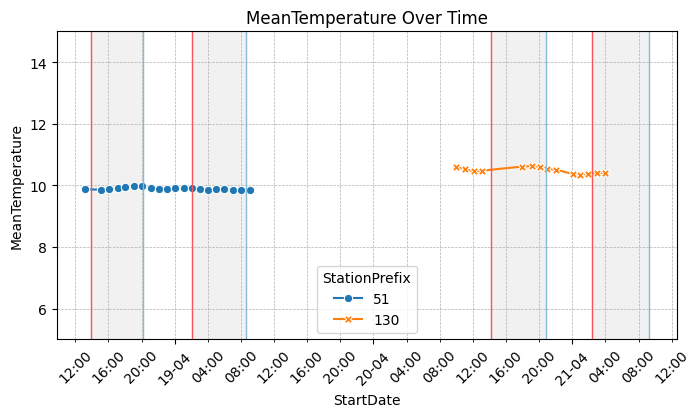

In [22]:
plot_environmental_variable(ctd_data, tides_df, 'MeanTemperature', (5, 15), '../figures/environmental')

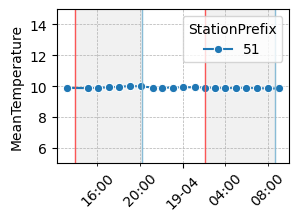

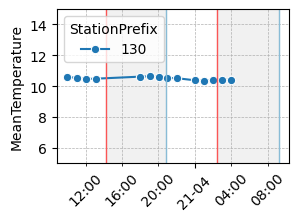

In [23]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTemperature', (5, 15), '../figures/environmental')

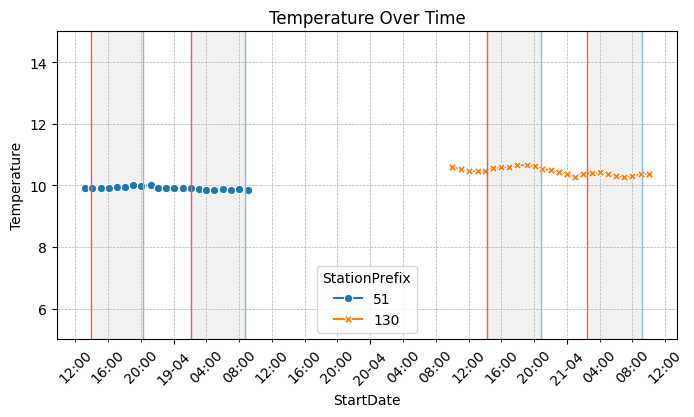

In [24]:
plot_environmental_variable(ctd_data, tides_df, 'Temperature', (5, 15), '../figures/environmental')

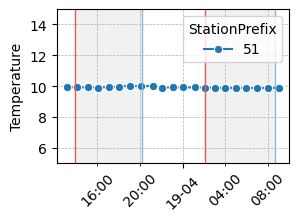

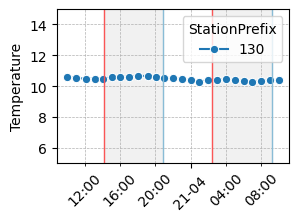

In [25]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Temperature', (5, 15), '../figures/environmental')

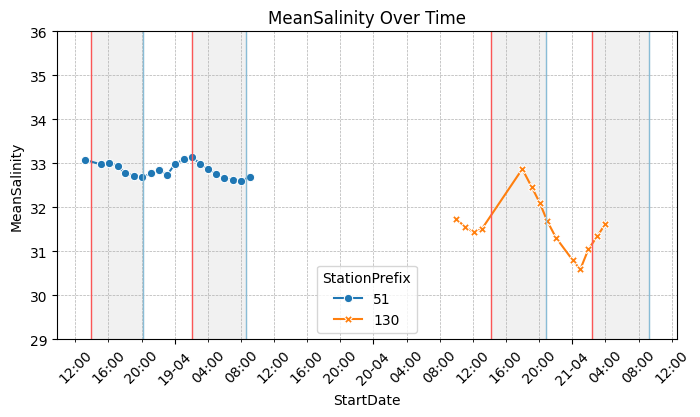

In [26]:
plot_environmental_variable(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

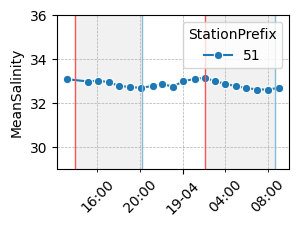

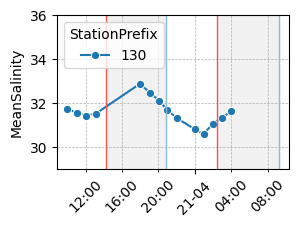

In [27]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

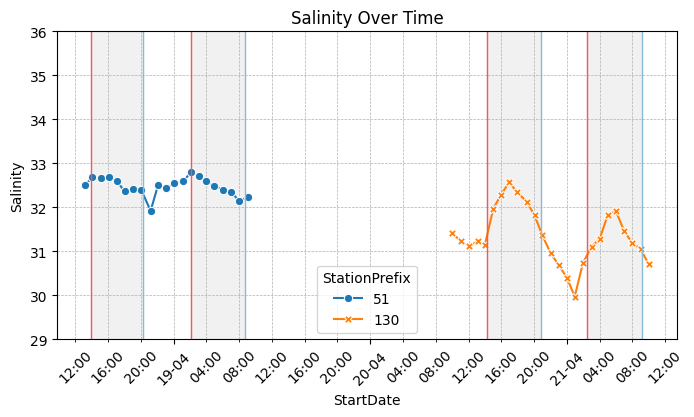

In [28]:
plot_environmental_variable(ctd_data, tides_df, 'Salinity', (29, 36), '../figures/environmental')

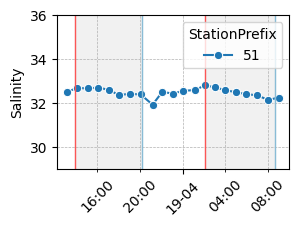

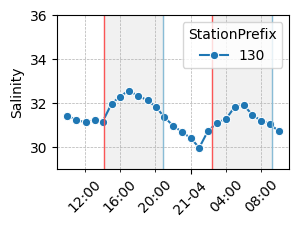

In [56]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Salinity', (29, 36), '../figures/environmental')

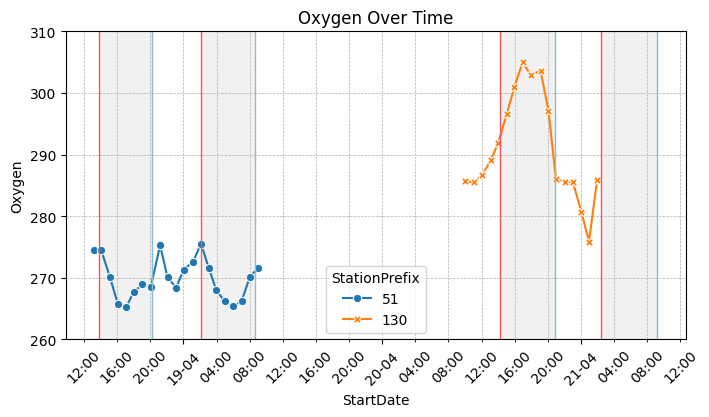

In [30]:
plot_environmental_variable(ctd_data, tides_df, 'Oxygen', (260, 310), '../figures/environmental')

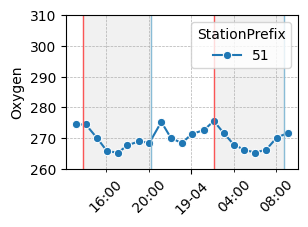

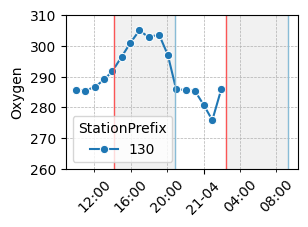

In [59]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Oxygen', (260, 310), '../figures/environmental')

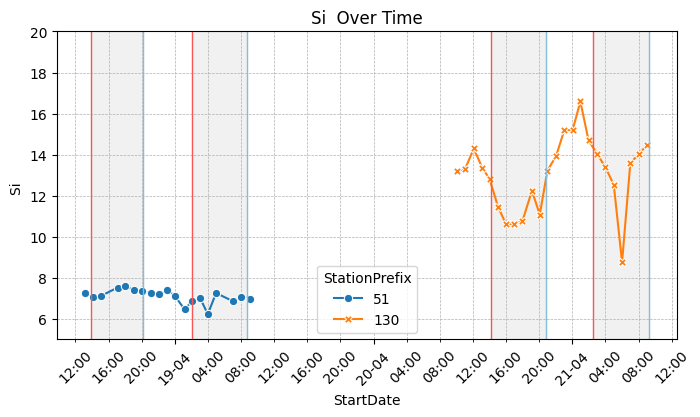

In [32]:
plot_environmental_variable(ctd_data, tides_df, 'Si ', (5, 20), '../figures/environmental')

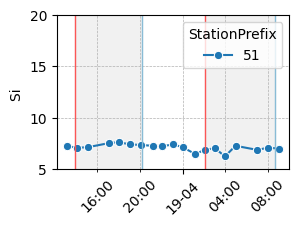

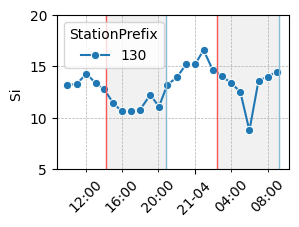

In [33]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Si ', (5, 20), '../figures/environmental')

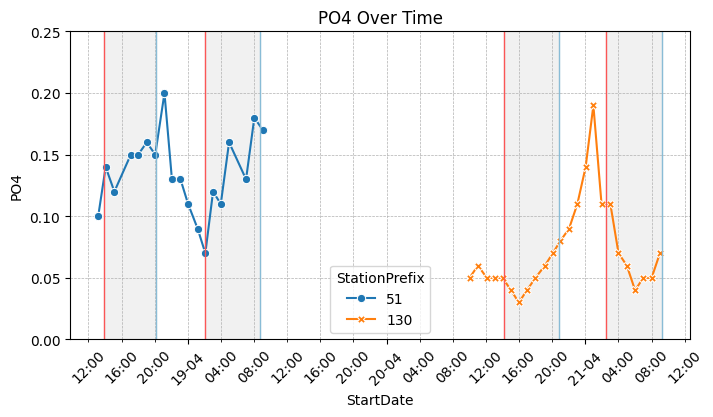

In [34]:
plot_environmental_variable(ctd_data, tides_df, 'PO4', (0, 0.25), '../figures/environmental')

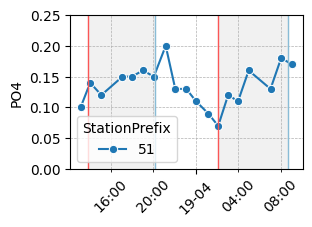

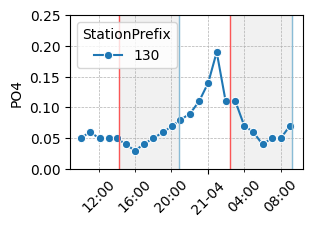

In [35]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'PO4', (0, 0.25), '../figures/environmental')

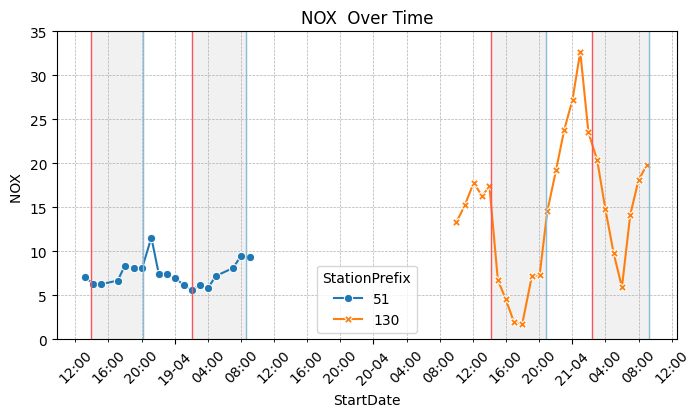

In [36]:
plot_environmental_variable(ctd_data, tides_df, 'NOX ', (0, 35), '../figures/environmental')

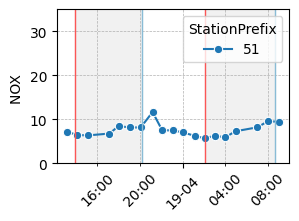

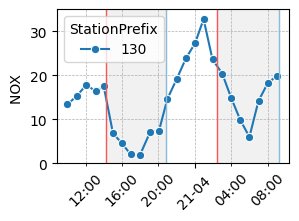

In [37]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NOX ', (0, 35), '../figures/environmental')

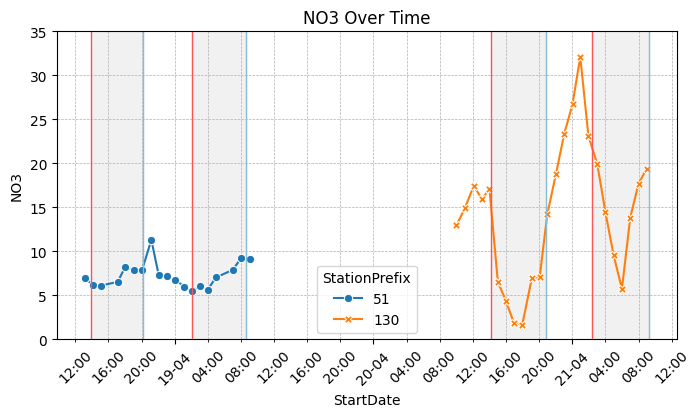

In [38]:
plot_environmental_variable(ctd_data, tides_df, 'NO3', (0, 35), '../figures/environmental')

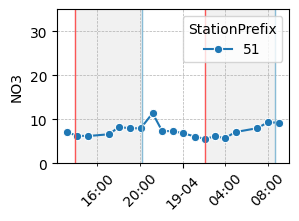

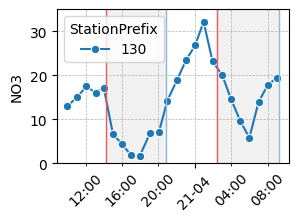

In [39]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NO3', (0, 35), '../figures/environmental')

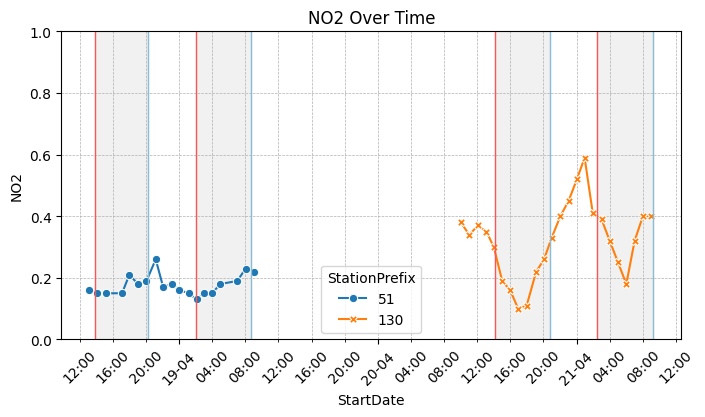

In [40]:
plot_environmental_variable(ctd_data, tides_df, 'NO2', (0, 1), '../figures/environmental')

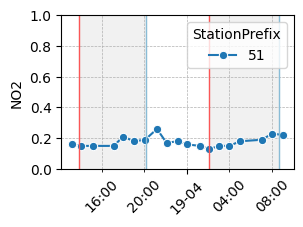

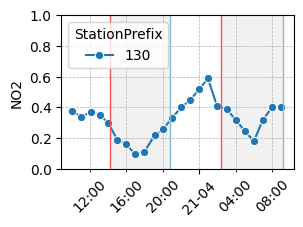

In [41]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NO2', (0, 1), '../figures/environmental')

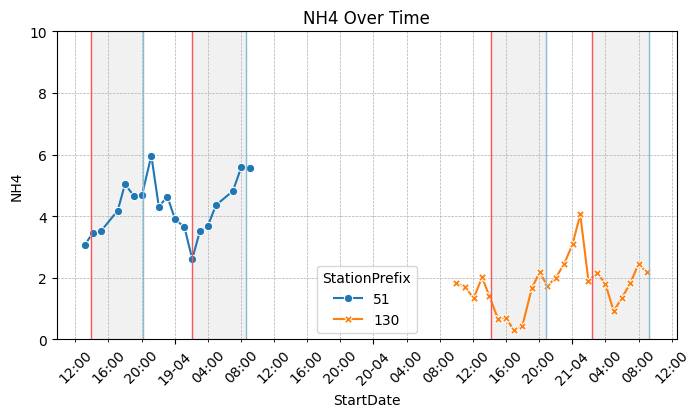

In [42]:
plot_environmental_variable(ctd_data, tides_df, 'NH4', (0, 10), '../figures/environmental')

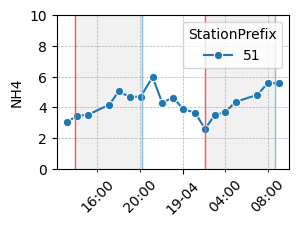

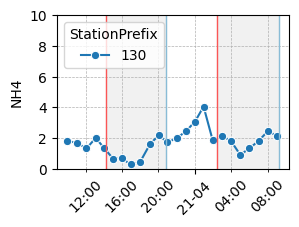

In [43]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NH4', (0, 10), '../figures/environmental')

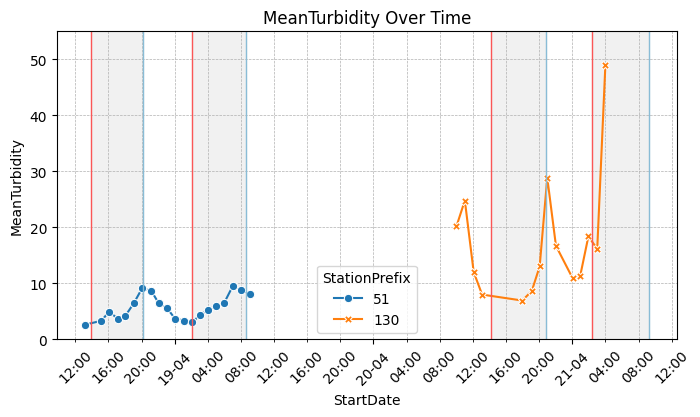

In [44]:
plot_environmental_variable(ctd_data, tides_df, 'MeanTurbidity', (0, 55), '../figures/environmental')

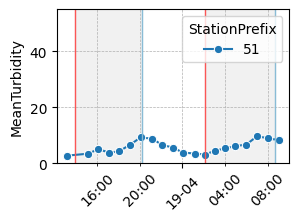

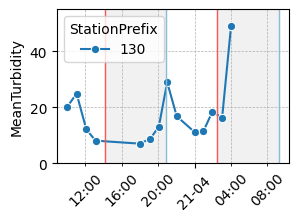

In [45]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTurbidity', (0, 55), '../figures/environmental')

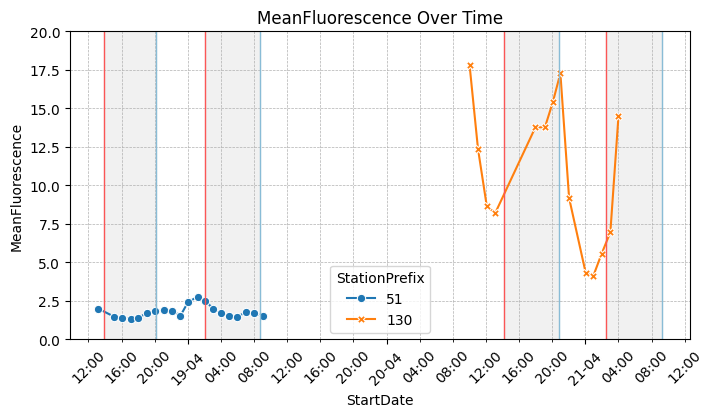

In [46]:
plot_environmental_variable(ctd_data, tides_df, 'MeanFluorescence', (0, 20), '../figures/environmental')

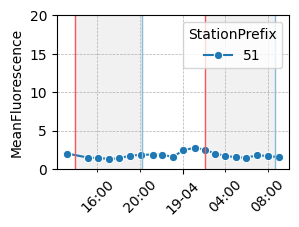

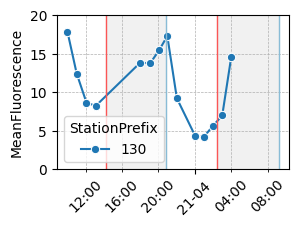

In [47]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanFluorescence', (0, 20), '../figures/environmental')

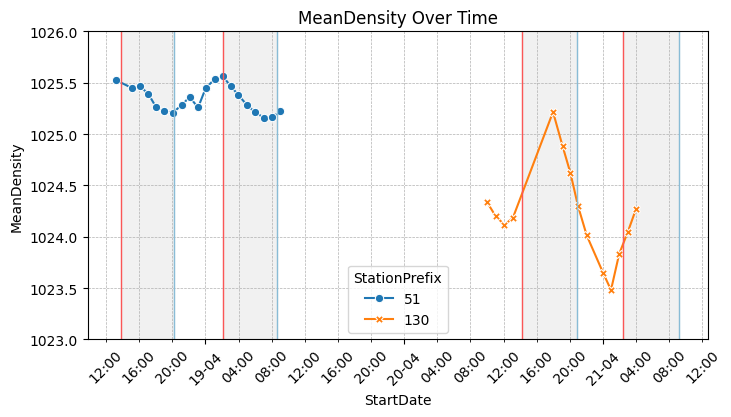

In [48]:
plot_environmental_variable(ctd_data, tides_df, 'MeanDensity', (1023, 1026), '../figures/environmental')

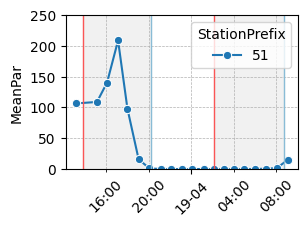

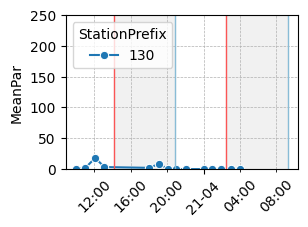

In [49]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanPar', (0, 250), '../figures/environmental')


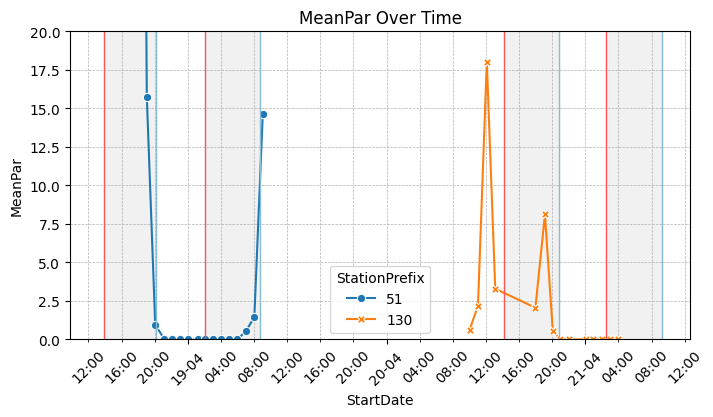

In [50]:
plot_environmental_variable(ctd_data, tides_df, 'MeanPar', (0, 20), '../figures/environmental')

In [9]:
ctd_data.columns

Index(['MeanConductivity', 'MeanDensity', 'MeanFluorescence', 'MeanPar',
       'MeanPressure', 'MeanSalinity', 'MeanSoundVelocity', 'MeanTemperature',
       'MeanTurbidity', 'NH4', 'NO2', 'NO3', 'NOX ', 'PO4', 'Si ', 'TEP',
       'StationPrefix', 'StationSuffix', 'StartLat', 'StartLong',
       'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen',
       'OxygenRaw', 'Station', 'Month', 'Year', 'Day', 'Hour', 'Minute'],
      dtype='object')

In [25]:
variable = 'Si '
# Print mean variance and standard deviation for each station for this variable
print(ctd_data.groupby('StationPrefix')[variable].agg(['mean', 'var', 'std']))

# Print the max value and the time of maximum value for this variable per station
print(ctd_data.groupby('StationPrefix')[variable].agg(['max', 'idxmax']))

# Print min value and the time of minimum value for this variable per station
print(ctd_data.groupby('StationPrefix')[variable].agg(['min', 'idxmin']))

                    mean       var       std
StationPrefix                               
130            13.057500  3.221576  1.794875
51              7.108421  0.114470  0.338334
                 max              idxmax
StationPrefix                           
130            16.59 2023-04-21 00:58:00
51              7.61 2023-04-18 18:00:00
                min              idxmin
StationPrefix                          
130            8.76 2023-04-21 06:00:00
51             6.23 2023-04-19 03:59:00


## Create environmental dataset for analysis
Here we'll combine the LW data, and buoy data, with sampling metadata in order to generate an easy dataset to work with in subsequent analyses. We'll pull in additional data using [bpnsdata](https://github.com/lifewatch/bpnsdata) if available.

In [51]:
# Clone the github package to the local machine and add it to the path
import sys
import os
sys.path.append('../../bpnsdata')
import bpnsdata
import geopandas as gpd
from suntime import Sun

In [52]:
os.environ['username_banken'] = 'michiel.perneel@vliz.be'
os.environ['password_banken'] = 'zYjjoj-kumtav-4himqe'

In [ ]:
# Add date column to the ctd_data
ctd_data['Date'] = ctd_data.index

# Run the sea_manager over every row in the dataframe for the ERDDAP data
env_vars = ['shipping', 'time', 'wrakken_bank', 'habitat_suitability',
            'seabed_habitat', 'sea_surface']

sea_manager = bpnsdata.SeaDataManager(env_vars=env_vars)

results = []  # List to hold the result from each row

for index, row in ctd_data.iterrows():
    try:
        # Convert the single row DataFrame to a GeoDataFrame
        single_row_gdf = gpd.GeoDataFrame([row], geometry=gpd.points_from_xy([row['StartLong']], [row['StartLat']]), crs='EPSG:4269')
        
        # Calculate day length
        sun = Sun(row['StartLat'], row['StartLong'])
        sunrise = sun.get_sunrise_time(row['Date'])
        sunset = sun.get_sunset_time(row['Date'])
        day_length = sunset - sunrise  # This will give you a timedelta object
        
        # Process the row
        result = sea_manager(single_row_gdf, datetime_column='Date')
        
        # Add day length
        result['day_length'] = day_length.total_seconds() / 3600  # Day length in hours
        
        # Append the result
        results.append(result)
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# Concatenate all results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

In [44]:
results_df.columns

Index(['MeanConductivity', 'MeanDensity', 'MeanFluorescence', 'MeanPar',
       'MeanPressure', 'MeanSalinity', 'MeanSoundVelocity', 'MeanTemperature',
       'MeanTurbidity', 'NH4', 'NO2', 'NO3', 'NOX ', 'PO4', 'Si ', 'TEP',
       'StationPrefix', 'StationSuffix', 'StartLat', 'StartLong',
       'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen',
       'OxygenRaw', 'Station', 'Month', 'Year', 'Day', 'Hour', 'Minute',
       'Date', 'geometry', 'route_density', 'moon_phase', 'day_moment',
       'shipwreck_distance', 'shipwreck_lat', 'shipwreck_lon',
       'benthic_habitat', 'substrate', 'seabed_habitat',
       'surface_baroclinic_eastward_sea_water_velocity',
       'surface_baroclinic_northward_sea_water_velocity',
       'sea_surface_height_above_sea_level', 'sea_surface_salinity',
       'sea_surface_temperature', 'surface_baroclinic_sea_water_velocity',
       'day_length'],
      dtype='object')

In [45]:
# Create a dictionary to map old column names to new ones
column_rename_map = {
    'MeanFluorescence': 'Fluorescence',
    'NH4': 'NH4',
    'NO2': 'NO2',
    'NO3': 'NO3',
    'NOX ': 'NOX',  # Ensure there is no extra space after 'NOX'
    'PO4': 'PO4',
    'Si ': 'Si',    # Ensure there is no extra space after 'Si'
    'TEP': 'TEP',
    'StationPrefix': 'StationPrefix',
    'StationSuffix': 'StationSuffix',
    'StartLat': 'Latitude',
    'StartLong': 'Longitude',
    'Temperature': 'Temperature',
    'Salinity': 'Salinity',
    'Conductivity': 'Conductivity',
    'Depth': 'Depth',
    'Oxygen': 'Oxygen',
    'Station': 'Station',
    'Date': 'Date',
    'day_moment': 'day_moment',
    'sea_surface_height_above_sea_level': 'sea_surface_height_above_sea_level',
    'surface_baroclinic_sea_water_velocity': 'surface_baroclinic_sea_water_velocity',
    'day_length': 'day_length'
}

# Select the columns of interest and rename them in one step
results_df = results_df[list(column_rename_map.keys())].rename(columns=column_rename_map)

# Reorder columns to put 'Station' first
ordered_columns = ['Station', 'StationPrefix', 'StationSuffix', 'Latitude', 'Longitude', 'Date', 'day_moment', 'day_length',
                   'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen', 'Fluorescence', 'NH4', 'NO2', 'NO3', 'NOX', 
                   'PO4', 'Si', 'TEP', 'sea_surface_height_above_sea_level', 'surface_baroclinic_sea_water_velocity']

results_df = results_df[ordered_columns]

# Save the results to a CSV file
results_df.to_csv('../data/samples_env.csv', index=False)

### CTD depth profiles
Now, we'll visualize the depth profiles collected with CTD at the two stations.
The goal is to create a plot with depth on the y-axis and temperature on the x-axis, with salinity on the right y-axis. We'll visualize time with color.
CTD Depth data has the following available columns:

- **Station**: Name or code of sampling station or receiver code.
- **CastId**: Unique identifier to specify a single CTD-cast.
- **Depth**: Bottom depth to surface from echosounder 200Hz in m.
- **Status**: An identifier to specify whether a specific measurement was taken in the up-cast, the down-cast, near the bottom, or during the calibration-phase at the surface.
- **Latitude**: Center latitude in decimal degrees, WGS84.
- **Longitude**: Center longitude in decimal degrees, WGS84.
- **Time**: Time in UTC, beginning of sample timeperiod.
- **Obs3+**: Turbidity measured by the CTD (expressed in NTU)
- **AltM**: Altimetry measured by the CTD (expressed in m).
- **Par**: Photosynthetic Active Radiation.
- **FIECO-AFL**: Fluorescence measured by the CTD (expressed in mg/m3).
- **Oxigenvoltage**: Oxygen measured by the CTD (expressed in V).
- **Sbeox0Mg/L**: Oxygen measured by CTD (expressed in mg/L).
- **Sbeox0PS**: Oxygen percentage measured by CTD.
- **PrdM**: Pressure measured by the CTD (expressed in db).
- **Temperature**: Temperature of air or the water body, expressed in degrees Celcius.
- **C0uS/cm**: Conducitivity of the water body, expressed in ms/cm.
- **Salinity**: Salinity of the water body, expressed in PSU.
- **Soundspeed**: The velocity of sound through the water body, expressed in m/s.
- **Density**: Calculated densities of zooplankton expressed in specimens/m³, by using the count, fraction, volumeM or volumeC.
- **DescSpeed**: The speed by which the CTD-carroussel was winched through the water column, expressed in m/s.
- **Flag**: A quality flag associated with a certain measurement.

In [138]:
ctd_depth = pd.read_csv('../data/raw/CTD_casts.csv')

# If present, remove the 'JN_22' prefix from the STATION column
ctd_depth['STATION'] = ctd_depth['STATION'].str.replace('JN22_', '')

# Split STATION column into Station and cast, only retain the first two columns
ctd_depth[['station', 'cast']] = ctd_depth['STATION'].str.split('_', expand=True)

# Only keep station 51 and 130
ctd_depth = ctd_depth[ctd_depth['station'].isin(['51', '130'])]

# Only consider samples deeper than 1 meters
ctd_depth = ctd_depth[ctd_depth['DEPTH'] > 1]

# Convert the DATE column to a datetime object
ctd_depth['date'] = pd.to_datetime(ctd_depth['sampletime'])

# Add a hour column
ctd_depth['hour'] = ctd_depth['date'].dt.hour

# Re-do the status column as the flags might be incorrect
## First, add a new status column
ctd_depth['status_2'] = 'downcast/soaking'
## For every cast, figure out the maximum depth of the cast and flag every sample that was taken after the deepest point as upcast
for cast in ctd_depth['STATION'].unique():
    max_depth = ctd_depth[ctd_depth['STATION'] == cast]['DEPTH'].max()
    cutoff_time = ctd_depth.loc[(ctd_depth['STATION'] == cast) & (ctd_depth['DEPTH'] == max_depth), 'date'].values[0]
    ctd_depth.loc[(ctd_depth['STATION'] == cast) & (ctd_depth['date'] >= cutoff_time), 'status_2'] = 'upcast'

# Ensure parameters are numeric (if needed, convert and handle errors)
ctd_depth['DEPTH'] = pd.to_numeric(ctd_depth['DEPTH'], errors='coerce')
# Convert density to numeric, density is a string with a comma separating 1000s
ctd_depth['density'] = ctd_depth['density'].str.replace(',', '')
ctd_depth['density'] = pd.to_numeric(ctd_depth['density'], errors='coerce')
ctd_depth['par'] = pd.to_numeric(ctd_depth['par'], errors='coerce')

# Remove rows with depth values that below 0
ctd_depth = ctd_depth[ctd_depth['DEPTH'] > 0]

ctd_depth.head()

STATION  castId  Latitude  Longitude              sampletime  DEPTH  \
5327    51_1    6324  51.53183     3.1825  2023-04-18 11:00:39.75  1.002   
5328    51_1    6324  51.53183     3.1825   2023-04-18 11:00:40.0  1.095   
5329    51_1    6324  51.53183     3.1825  2023-04-18 11:00:40.25  1.175   
5330    51_1    6324  51.53183     3.1825   2023-04-18 11:00:40.5  1.233   
5331    51_1    6324  51.53183     3.1825  2023-04-18 11:00:40.75  1.264   

        obs3+  altM     par  flECO-AFL  ...  soundspeed    density  descSpeed  \
5327  12.1173 -0.67  562.96     0.9257  ...    1,486.78  1025.2138    0.09425   
5328   7.9749 -0.66  461.14     0.9237  ...    1,486.78  1025.2153    0.10200   
5329   5.5177 -0.67  421.55     0.9216  ...    1,486.78  1025.2107    0.10175   
5330   4.1576 -0.66  424.65     0.9220  ...    1,486.76  1025.2044    0.09550   
5331   3.5958 -0.67  465.32     0.9204  ...    1,486.74  1025.2044    0.08350   

      flag    status  station  cast                    date  hour  \
5327     0  downcast       51     1 2023-04-18 11:00:39.750    11   
5328     0  downcast       51     1 2023-04-18 11:00:40.000    11   
5329     0  downcast       51     1 2023-04-18 11:00:40.250    11   
5330     0  downcast       51     1 2023-04-18 11:00:40.500    11   
5331     0  downcast       51     1 2023-04-18 11:00:40.750    11   

              status_2  
5327  downcast/soaking  
5328  downcast/soaking  
5329  downcast/soaking  
5330  downcast/soaking  
5331  downcast/soaking  

[5 rows x 29 columns]

In [111]:
ctd_depth.columns

Index(['STATION', 'castId', 'Latitude', 'Longitude', 'sampletime', 'DEPTH',
       'obs3+', 'altM', 'par', 'flECO-AFL', 'oxigenvoltage', 'ph',
       'sbeox0Mg/L', 'sbeox0PS', 'turbWETntu0', 'prdM', 'TEMP', 'C0uS/cm',
       'PSAL', 'soundspeed', 'density', 'descSpeed', 'flag', 'status',
       'station', 'cast', 'date', 'hour'],
      dtype='object')

In [ ]:
# Create a diel color palette
cmap_orig = plt.get_cmap("coolwarm")
colors = cmap_orig(np.concatenate((np.linspace(0,1,128), np.linspace(1,0,128))))
cmap = ListedColormap(colors)
plt.cm.register_cmap("cycliccoolwarm", cmap=cmap)

In [116]:
ctd_depth['status'].unique()

array(['downcast', 'upcast', 'bottom', 'upsoak'], dtype=object)

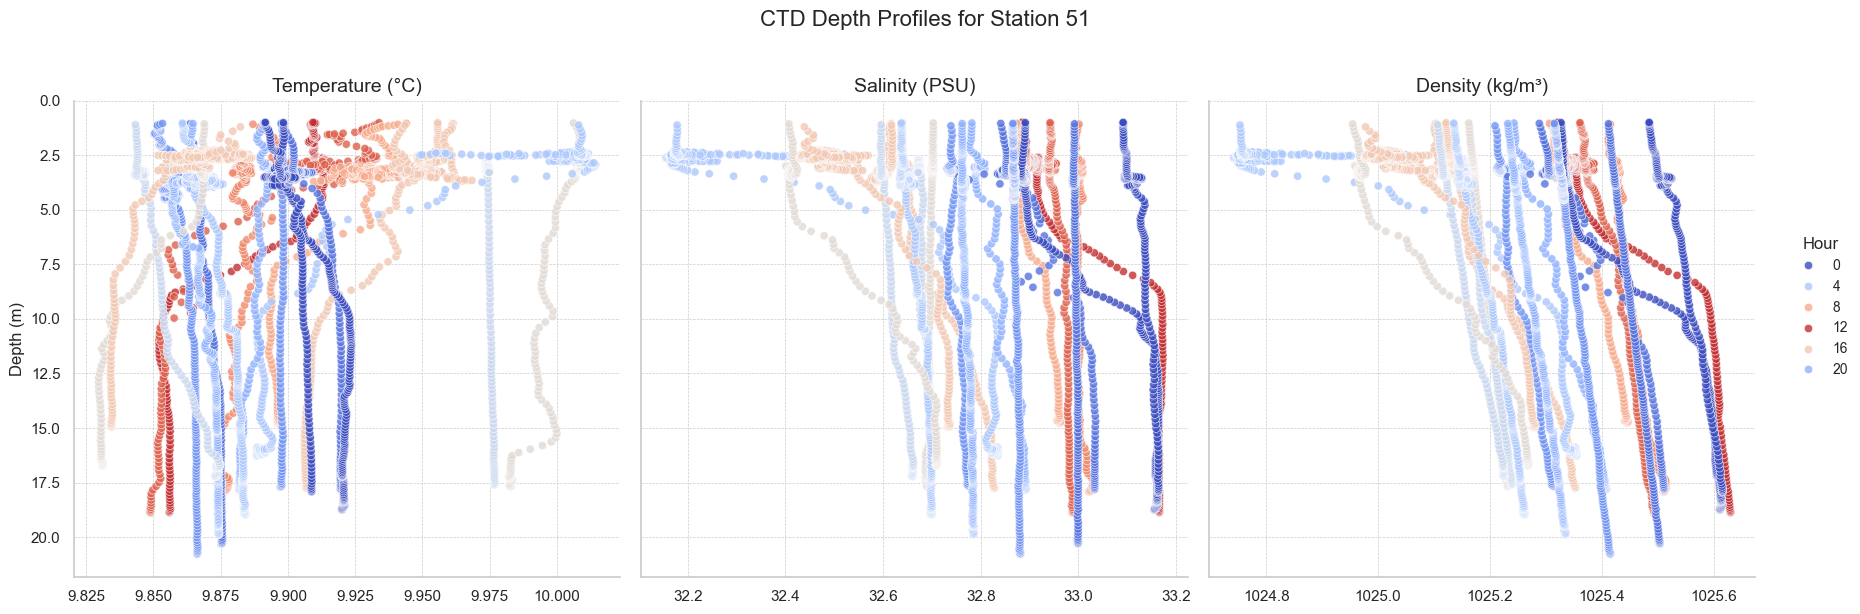

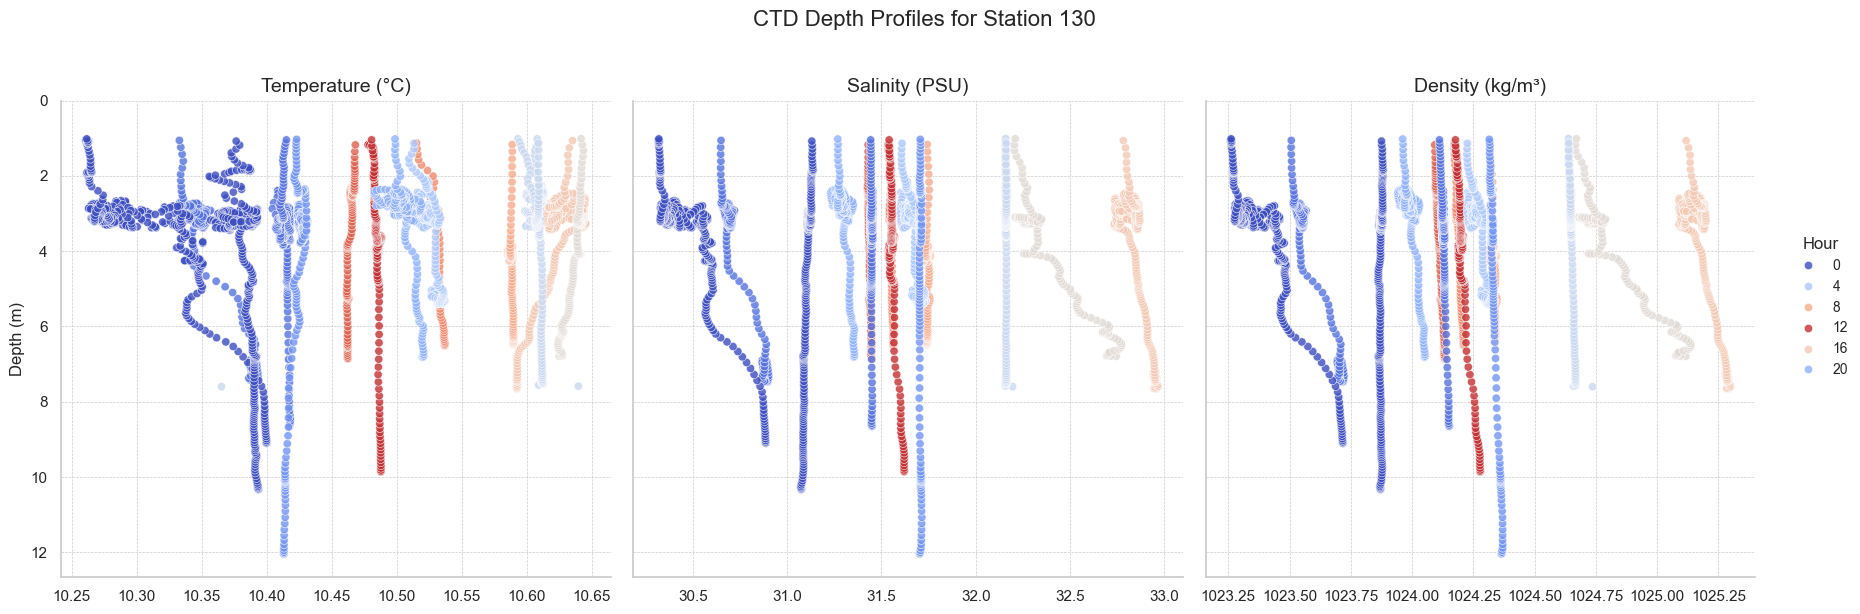

In [139]:
# Define parameters to plot
parameters = {
    'TEMP': 'Temperature (°C)',
    'PSAL': 'Salinity (PSU)',
    'density': 'Density (kg/m³)'
}

# Create depth profiles using FacetGrid
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]
    
    # Only consider the upcast data
    station_depth = station_depth[station_depth['status_2'] == 'upcast']

    # Melt the data to a long format for FacetGrid
    melted_depth = station_depth.melt(
        id_vars=['DEPTH', 'hour'],
        value_vars=parameters.keys(),
        var_name='Parameter',
        value_name='Value'
    )

    # Map parameter names to labels
    melted_depth['Parameter'] = melted_depth['Parameter'].map(parameters)

    # Determine the maximum depth in the dataset
    max_depth = station_depth['DEPTH'].max()


    # Create the FacetGrid
    g = sns.FacetGrid(
        melted_depth,
        col='Parameter',
        sharey=True,
        sharex=False,
        height=6,
        aspect=1
    )

    # Plot scatterplots on the FacetGrid
    g.map_dataframe(
        sns.scatterplot,
        x='Value',
        y='DEPTH',
        hue='hour',
        palette="cycliccoolwarm",
        alpha=0.8,
        marker='o',
    )

    # Apply y-axis settings explicitly for each subplot
    for ax in g.axes.flat:
        ax.set_ylim(0, max_depth * 1.05)  # Set 0 as the surface level and max depth as the bottom
        ax.set_ylim(ax.get_ylim()[::-1])  # Reverse the y-axis limits (invert depth)
        ax.grid(True, linestyle='--', linewidth=0.5)

    # Adjust titles and labels
    g.set_titles(col_template="{col_name}", size=14)
    g.set_axis_labels('', 'Depth (m)', size=12)
    g.add_legend(title="Hour", title_fontsize=12, fontsize=10)

    # Set the title for the entire grid
    g.fig.suptitle(f'CTD Depth Profiles for Station {station}', fontsize=16, y=1.02)

    # Adjust layout and save
    g.tight_layout()
    g.savefig(f'../figures/environmental/depth_profiles_station_{station}.svg', format='svg', dpi=600)
    g.savefig(f'../figures/environmental/depth_profiles_station_{station}.png', format='png', dpi=600)

    # Show the plot
    plt.show()

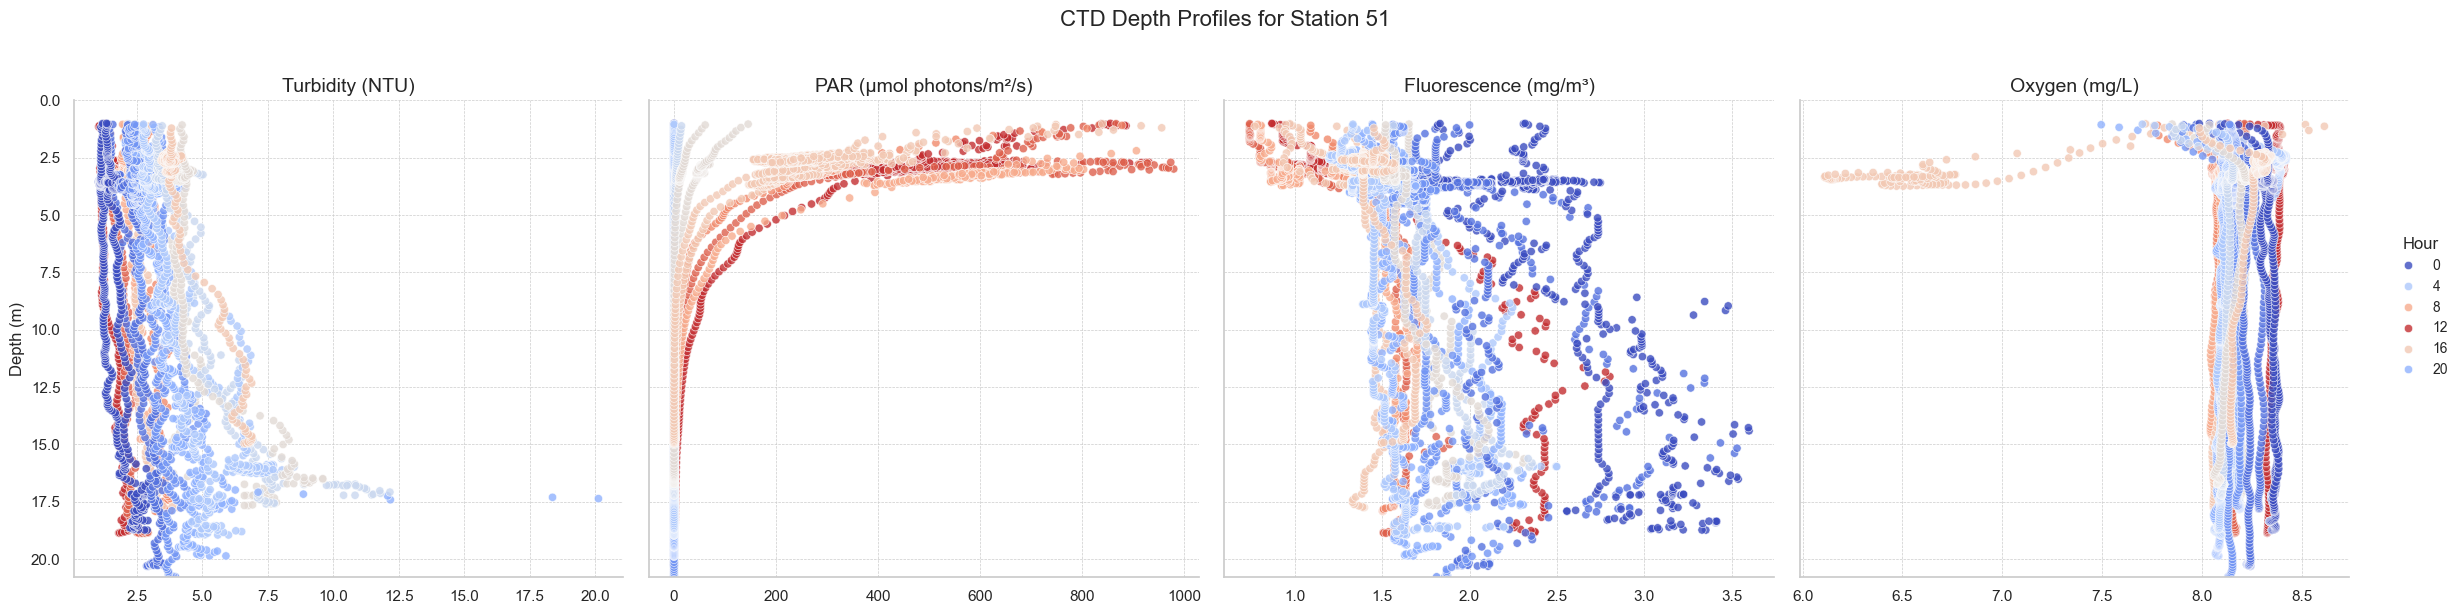

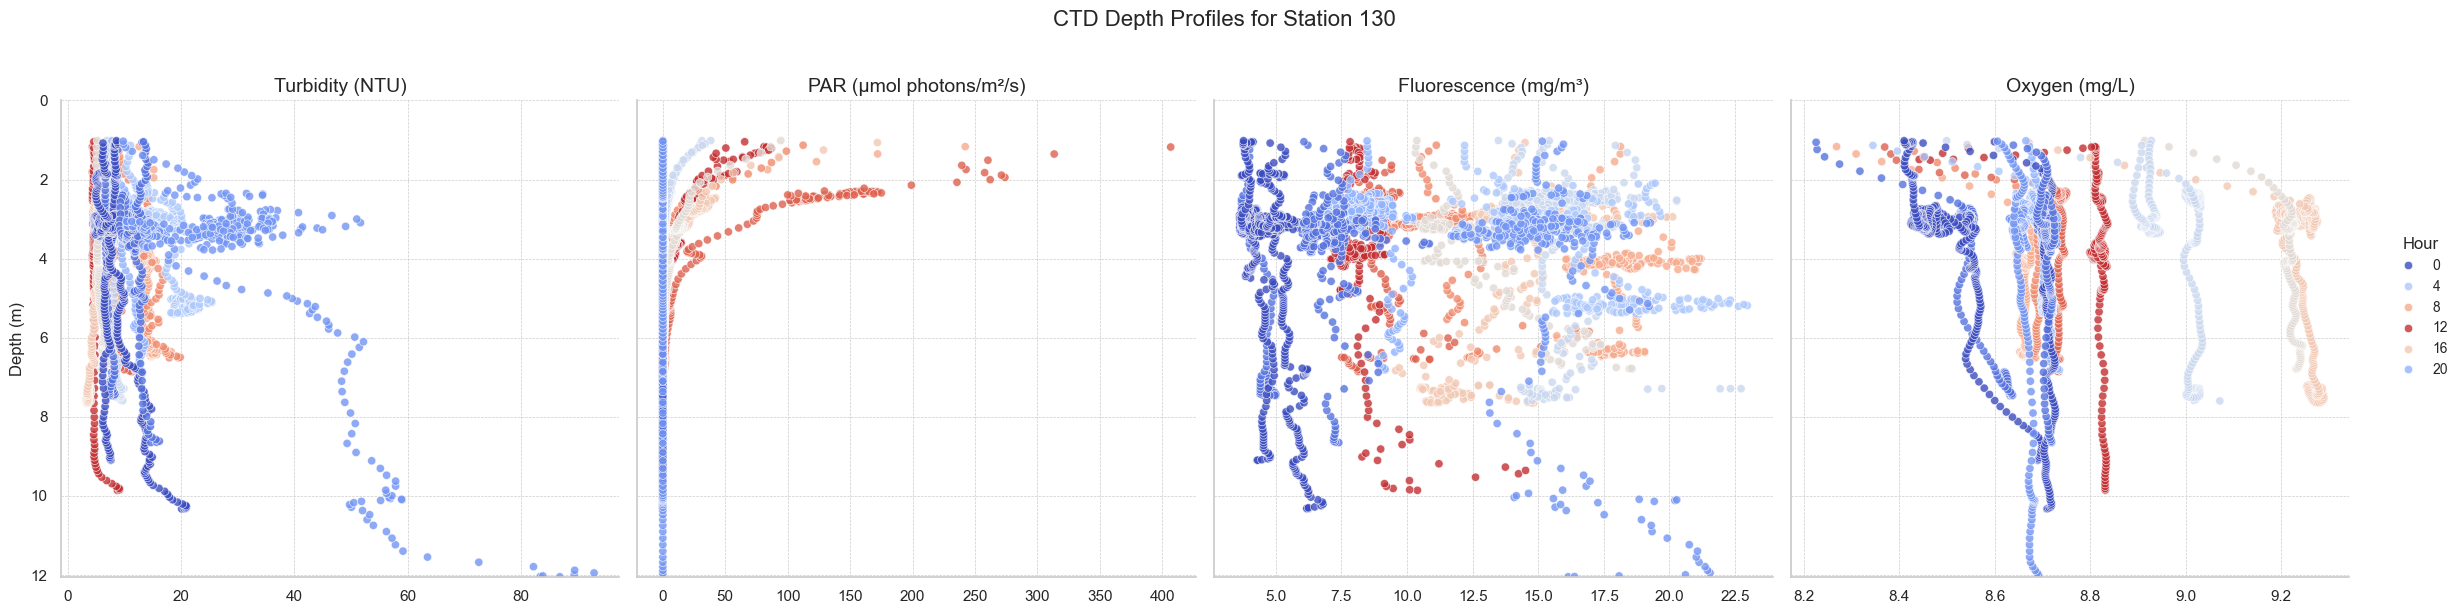

In [144]:
# Define parameters to plot
parameters = {
    'obs3+': 'Turbidity (NTU)',
    'par': 'PAR (µmol photons/m²/s)',
    'flECO-AFL': 'Fluorescence (mg/m³)',
    'sbeox0Mg/L': 'Oxygen (mg/L)'
}

# Create depth profiles using FacetGrid
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]
    
    # Only consider the upcast data
    station_depth = station_depth[station_depth['status_2'] == 'upcast']
    
    # Remove oxygen outliers
    station_depth = station_depth[station_depth['sbeox0Mg/L'] > 0]

    # Melt the data to a long format for FacetGrid
    melted_depth = station_depth.melt(
        id_vars=['DEPTH', 'hour'],
        value_vars=parameters.keys(),
        var_name='Parameter',
        value_name='Value'
    )

    # Map parameter names to labels
    melted_depth['Parameter'] = melted_depth['Parameter'].map(parameters)

    # Determine the maximum depth in the dataset
    max_depth = station_depth['DEPTH'].max()

    # Create the FacetGrid
    g = sns.FacetGrid(
        melted_depth,
        col='Parameter',
        sharey=True,
        sharex=False,
        height=6,
        aspect=1
    )

    # Plot scatterplots on the FacetGrid
    g.map_dataframe(
        sns.scatterplot,
        x='Value',
        y='DEPTH',
        hue='hour',
        palette="cycliccoolwarm",
        alpha=0.8,
        marker='o',
    )

    # Apply y-axis settings explicitly for each subplot
    for ax in g.axes.flat:
        ax.set_ylim(0, max_depth)  # Set 0 as the surface level and max depth as the bottom
        ax.set_ylim(ax.get_ylim()[::-1])  # Reverse the y-axis limits (invert depth)
        ax.grid(True, linestyle='--', linewidth=0.5)

    # Adjust titles and labels
    g.set_titles(col_template="{col_name}", size=14)
    g.set_axis_labels('', 'Depth (m)', size=12)
    g.add_legend(title="Hour", title_fontsize=12, fontsize=10)

    # Set the title for the entire grid
    g.fig.suptitle(f'CTD Depth Profiles for Station {station}', fontsize=16, y=1.02)

    # Adjust layout and save
    g.tight_layout()
    g.savefig(f'../figures/environmental/depth_profiles_2_station_{station}.svg', format='svg', dpi=600)
    g.savefig(f'../figures/environmental/depth_profiles_2_station_{station}.png', format='png', dpi=600)

    # Show the plot
    plt.show()

In [ ]:
# Create a custom cyclic colormap for diel visualization
diel_colors = [
    (0.0, 0.0, 0.2),  # Midnight (dark blue)
    (0.0, 0.5, 1.0),  # Dawn (light blue)
    (1.0, 1.0, 0.5),  # Noon (yellowish white)
    (1.0, 0.5, 0.0),  # Dusk (orange)
    (0.0, 0.0, 0.2)   # Midnight (dark blue)
]
diel_cmap = LinearSegmentedColormap.from_list("DielCyclic", diel_colors, N=256)
plt.cm.register_cmap("diel_cyclic", diel_cmap)

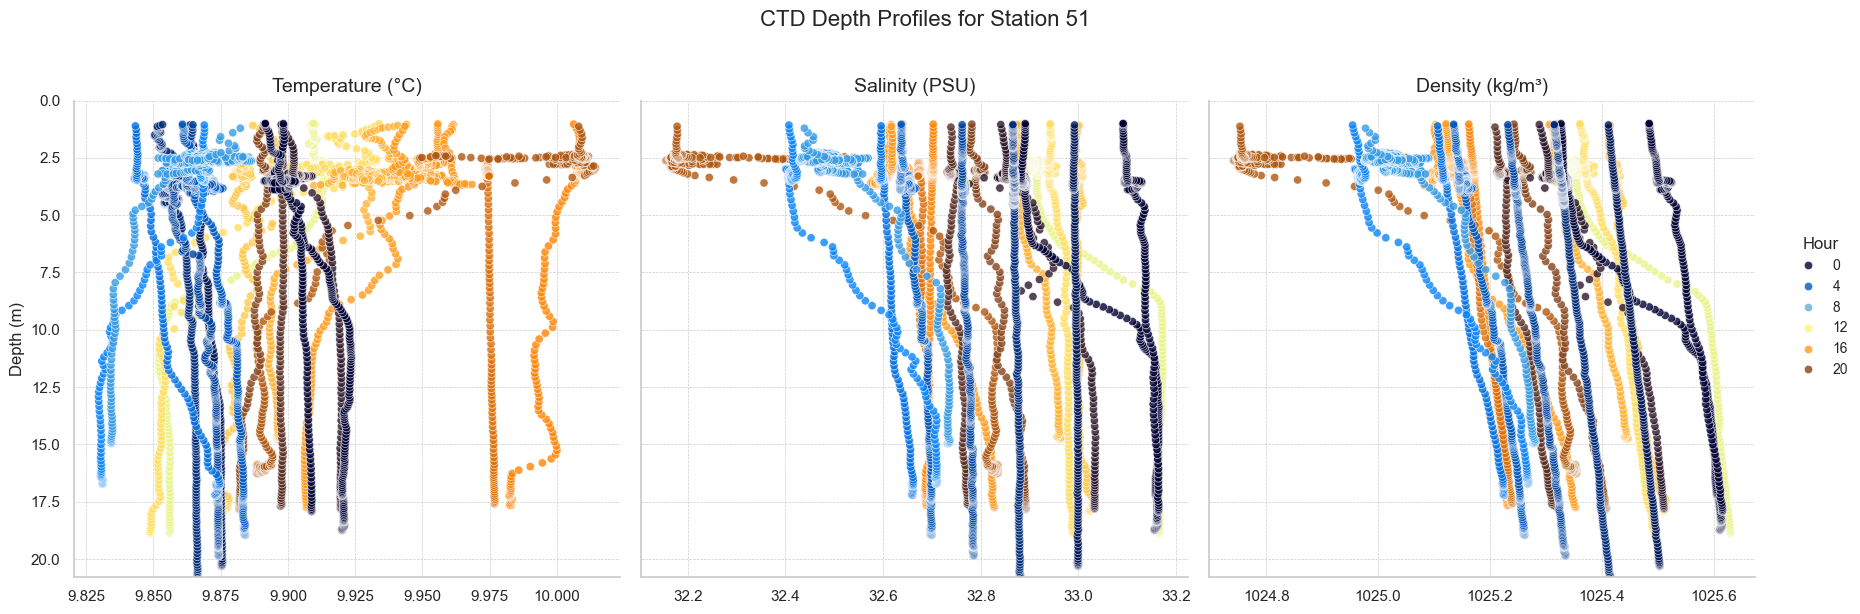

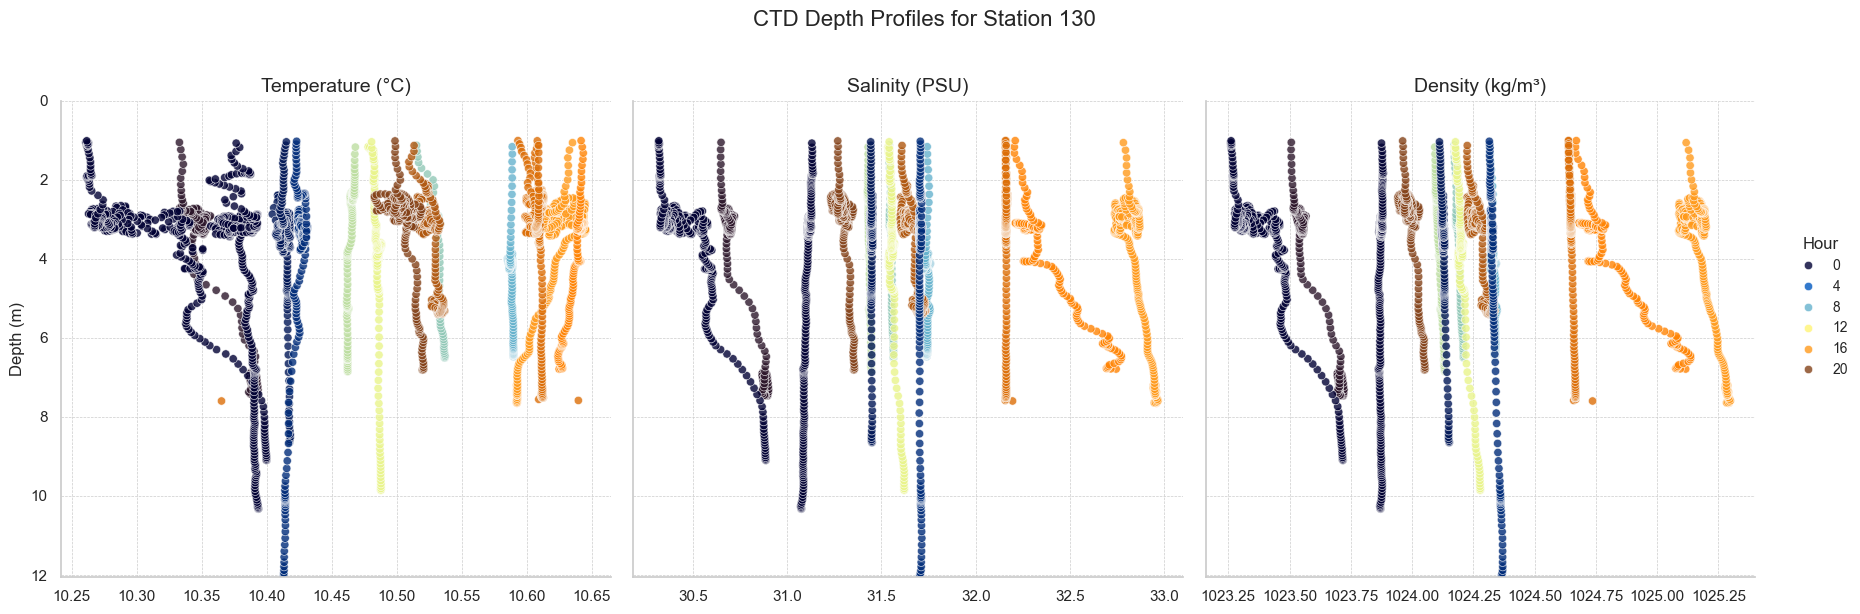

In [141]:
# Define parameters to plot
parameters = {
    'TEMP': 'Temperature (°C)',
    'PSAL': 'Salinity (PSU)',
    'density': 'Density (kg/m³)'
}

# Create depth profiles using FacetGrid
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]
    
    # Only consider the upcast data
    station_depth = station_depth[station_depth['status_2'] == 'upcast']

    # Melt the data to a long format for FacetGrid
    melted_depth = station_depth.melt(
        id_vars=['DEPTH', 'hour'],
        value_vars=parameters.keys(),
        var_name='Parameter',
        value_name='Value'
    )

    # Map parameter names to labels
    melted_depth['Parameter'] = melted_depth['Parameter'].map(parameters)

    # Determine the maximum depth in the dataset
    max_depth = station_depth['DEPTH'].max()

    # Create the FacetGrid
    g = sns.FacetGrid(
        melted_depth,
        col='Parameter',
        sharey=True,
        sharex=False,
        height=6,
        aspect=1
    )

    # Plot scatterplots on the FacetGrid
    g.map_dataframe(
        sns.scatterplot,
        x='Value',
        y='DEPTH',
        hue='hour',
        palette="diel_cyclic",
        alpha=0.8
    )

    # Apply y-axis settings explicitly for each subplot
    for ax in g.axes.flat:
        ax.set_ylim(0, max_depth)  # Set 0 as the surface level and max depth as the bottom
        ax.set_ylim(ax.get_ylim()[::-1])  # Reverse the y-axis limits (invert depth)
        ax.grid(True, linestyle='--', linewidth=0.5)

    # Adjust titles and labels
    g.set_titles(col_template="{col_name}", size=14)
    g.set_axis_labels('', 'Depth (m)', size=12)
    g.add_legend(title="Hour", title_fontsize=12, fontsize=10)

    # Set the title for the entire grid
    g.fig.suptitle(f'CTD Depth Profiles for Station {station}', fontsize=16, y=1.02)

    # Adjust layout and save
    g.tight_layout()
    g.savefig(f'../figures/environmental/profiles_B_station_{station}.svg', format='svg', dpi=600)
    g.savefig(f'../figures/environmental/profiles_B_station_{station}.png', format='png', dpi=600)

    # Show the plot
    plt.show()

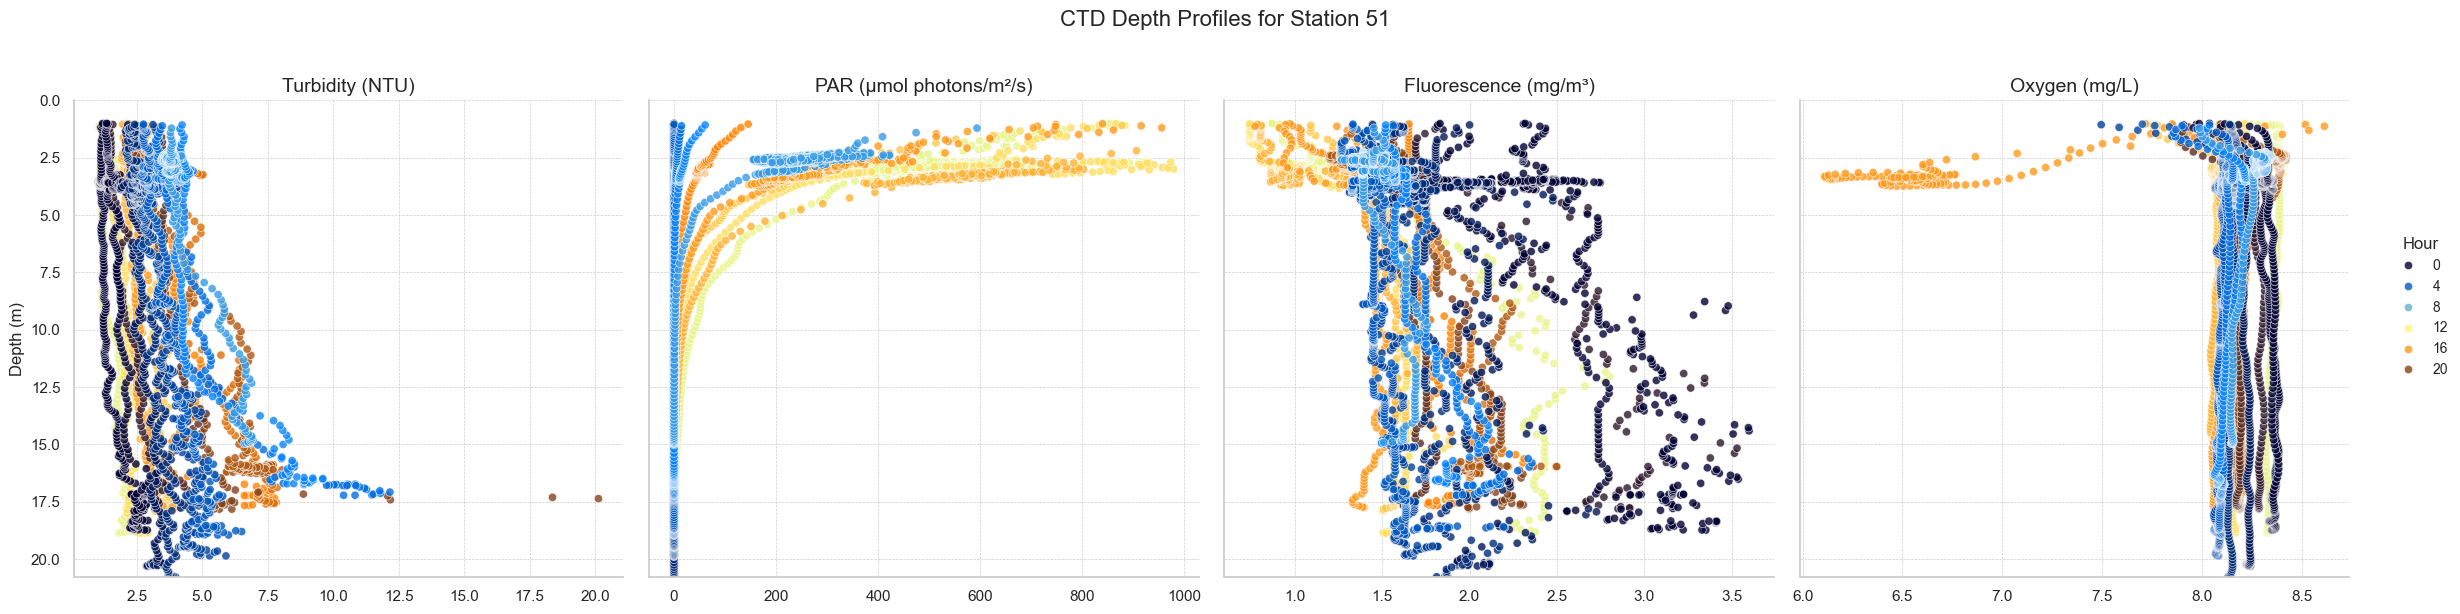

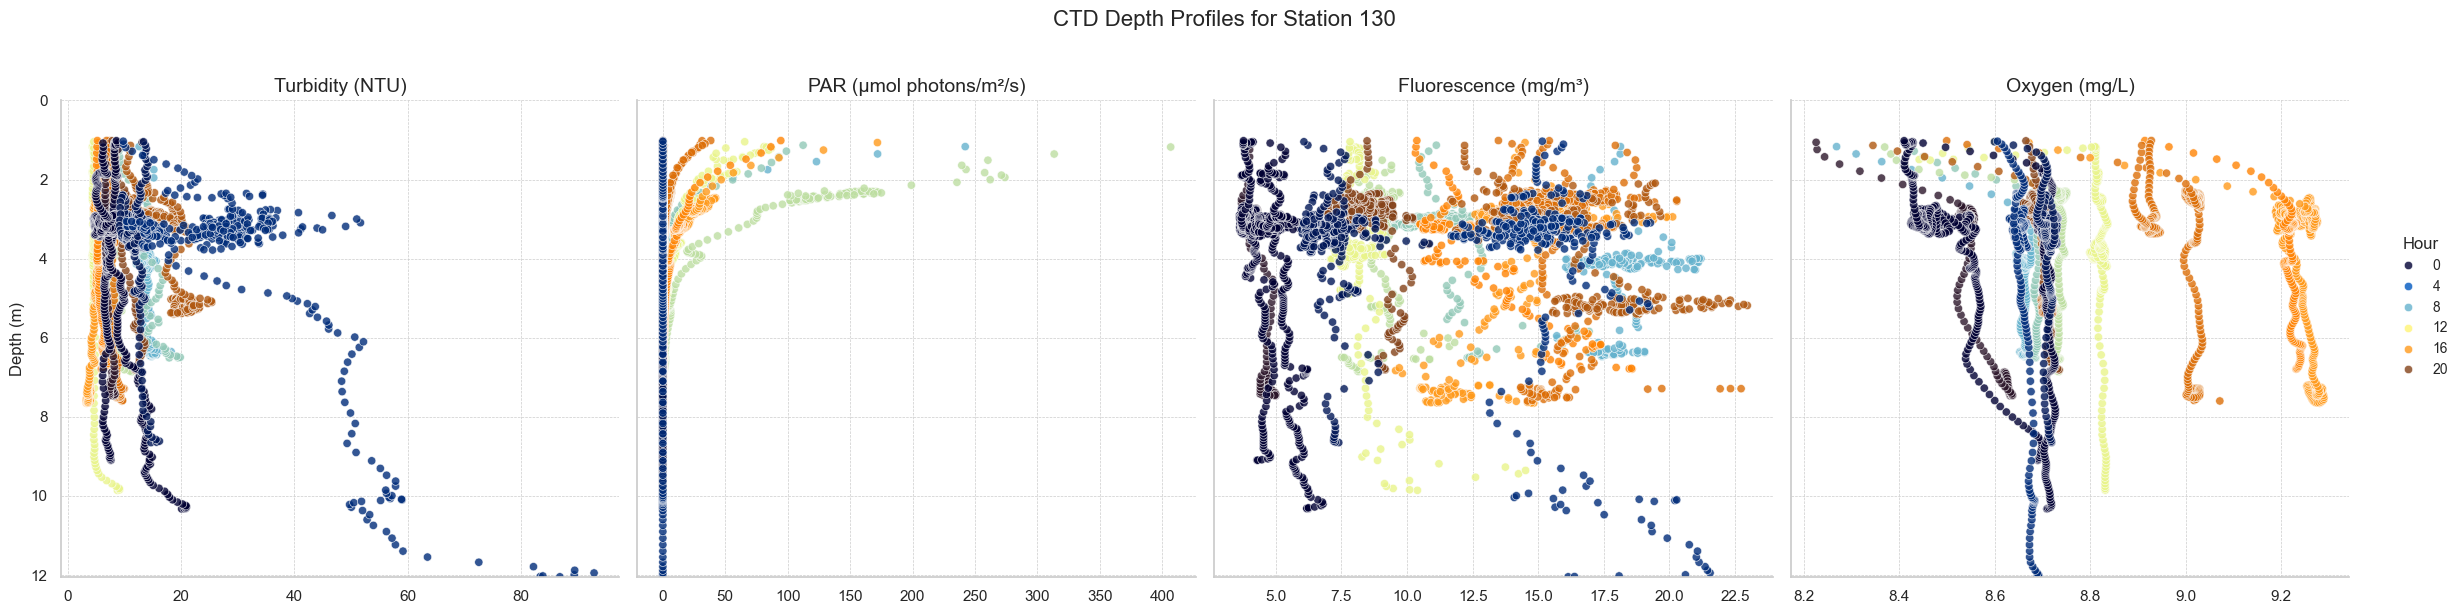

In [143]:
# Define parameters to plot
parameters = {
    'obs3+': 'Turbidity (NTU)',
    'par': 'PAR (µmol photons/m²/s)',
    'flECO-AFL': 'Fluorescence (mg/m³)',
    'sbeox0Mg/L': 'Oxygen (mg/L)'
}

# Create depth profiles using FacetGrid
for station in ['51', '130']:
    # Filter the CTD data for the current station
    station_depth = ctd_depth[ctd_depth['station'] == station]

    # Only consider the upcast data
    station_depth = station_depth[station_depth['status_2'] == 'upcast']
    
    # Remove oxygen outliers
    station_depth = station_depth[station_depth['sbeox0Mg/L'] > 0]
    
    # Melt the data to a long format for FacetGrid
    melted_depth = station_depth.melt(
        id_vars=['DEPTH', 'hour'],
        value_vars=parameters.keys(),
        var_name='Parameter',
        value_name='Value'
    )

    # Map parameter names to labels
    melted_depth['Parameter'] = melted_depth['Parameter'].map(parameters)

    # Determine the maximum depth in the dataset
    max_depth = station_depth['DEPTH'].max()

    # Create the FacetGrid
    g = sns.FacetGrid(
        melted_depth,
        col='Parameter',
        sharey=True,
        sharex=False,
        height=6,
        aspect=1
    )

    # Plot scatterplots on the FacetGrid
    g.map_dataframe(
        sns.scatterplot,
        x='Value',
        y='DEPTH',
        hue='hour',
        palette="diel_cyclic",
        alpha=0.8
    )

    # Apply y-axis settings explicitly for each subplot
    for ax in g.axes.flat:
        ax.set_ylim(0, max_depth)  # Set 0 as the surface level and max depth as the bottom
        ax.set_ylim(ax.get_ylim()[::-1])  # Reverse the y-axis limits (invert depth)
        ax.grid(True, linestyle='--', linewidth=0.5)

    # Adjust titles and labels
    g.set_titles(col_template="{col_name}", size=14)
    g.set_axis_labels('', 'Depth (m)', size=12)
    g.add_legend(title="Hour", title_fontsize=12, fontsize=10)

    # Set the title for the entire grid
    g.fig.suptitle(f'CTD Depth Profiles for Station {station}', fontsize=16, y=1.02)

    # Adjust layout and save
    g.tight_layout()
    g.savefig(f'../figures/environmental/depth_profiles_2B_station_{station}.svg', format='svg', dpi=600)
    g.savefig(f'../figures/environmental/depth_profiles_2B_station_{station}.png', format='png', dpi=600)

    # Show the plot
    plt.show()

## Dissolved C

In [7]:
# Setting the first row as headers and skipping unnecessary rows
dic = pd.read_csv('../data/raw/DIC_data.csv', delimiter=';', decimal=',')

In [8]:
dic.head()

Date      time station  salinity  temperature          DIC     stdev  \
0  17/04/2023  12:01:45     W08    32.875        9.852  2074.920000  0.962111   
1  17/04/2023  15:57:21     W08    33.735        9.866  2070.370000  1.333087   
2  17/04/2023  21:04:47     W08    33.542        9.867  2062.548571  0.758275   
3  18/04/2023  11:06:51      51    32.560        9.913  2176.040000  0.752064   
4  18/04/2023  14:59:58      51    32.595        9.929  2187.630000  0.942656   

        TA   stdev.1        pH   stdev.2      oxygen  
0  2333.54  1.174351  7.967628  0.000491  332.860000  
1  2334.88  0.545069  7.973908  0.003158         NaN  
2  2338.72       NaN  7.968121  0.001710  328.534834  
3  2412.30  0.834386  7.915864  0.002086  274.270784  
4  2411.85  2.375879  7.904972  0.003110         NaN

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_55249/2487883445.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dic['datetime'] = pd.to_datetime(filtered_dic['Date'] + ' ' + filtered_dic['time'], dayfirst=True)


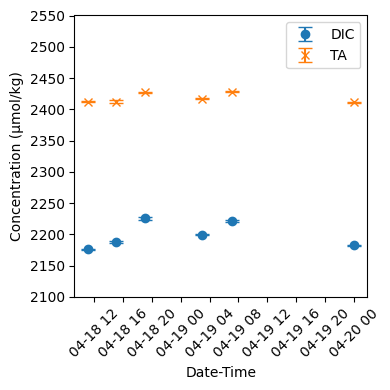

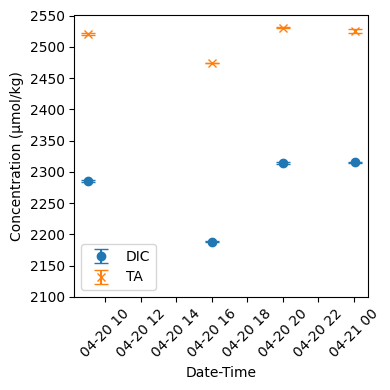

In [18]:
# For station 51 and 130, visualize the DIC data over time
filtered_dic = dic[dic['station'].str.contains('51|130', na=False)]

# Converting the 'Date' and 'time' columns into a combined datetime column for finer resolution
filtered_dic['datetime'] = pd.to_datetime(filtered_dic['Date'] + ' ' + filtered_dic['time'], dayfirst=True)

# Splitting data by station
station_51_data = filtered_dic[filtered_dic['station'] == '51']
station_130_data = filtered_dic[filtered_dic['station'] == '130']

# Plotting DIC and TA for station 51 with error bars
plt.figure(figsize=(4, 4))
plt.errorbar(
    station_51_data['datetime'], station_51_data['DIC'],
    yerr=station_51_data['stdev'], label='DIC', fmt='o', capsize=5
)
plt.errorbar(
    station_51_data['datetime'], station_51_data['TA'],
    yerr=station_51_data['stdev.1'], label='TA', fmt='x', capsize=5
)
plt.xlabel('Date-Time')
plt.ylabel('Concentration (µmol/kg)')
plt.ylim(2100, 2550)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting DIC and TA for station 130 with error bars
plt.figure(figsize=(4, 4))
plt.errorbar(
    station_130_data['datetime'], station_130_data['DIC'],
    yerr=station_130_data['stdev'], label='DIC', fmt='o', capsize=5
)
plt.errorbar(
    station_130_data['datetime'], station_130_data['TA'],
    yerr=station_130_data['stdev.1'], label='TA', fmt='x', capsize=5
)
plt.xlabel('Date-Time')
plt.ylabel('Concentration (µmol/kg)')
plt.ylim(2100, 2550)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()